<a href="https://colab.research.google.com/github/Veewy/AML/blob/main/AML_3)_LSTM_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌹 **Anti Money Laundering**  🌹

# **Data Import**

In [2]:
!pip install optuna

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch                      # for PyTorch operations
import torch.nn as nn             # for neural network modules
import torch.optim as optim       # for optimization functions
import optuna                     # library for hyperparameter tuning
import os                         # for file, directory operations (e.g., saving models,logs)
from sklearn.metrics import (
    f1_score, roc_auc_score, precision_score, recall_score,
    ConfusionMatrixDisplay, confusion_matrix, auc, roc_curve
)
from functools import partial     # for creating a partial function with fixed arguments
from torch.utils.data import Dataset, DataLoader # for handling datasets and data loading
from torch.optim.lr_scheduler import ReduceLROnPlateau # for dynamic learning rate adjustments

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DataSet** / **DataLoader**

In [6]:
class AmlDataset(Dataset):
    def __init__(self, data, features):
        """
        @param data: pdf whose index is monotonically increases from 0
        @param features: list of features to be used in an event
        """
        self.data = data
        self.features = features

    def __getitem__(self, index):
        psr_sample = self.data.iloc[index] #retrieves row at specified index from the data.
        list_y = psr_sample["targets"]
        list_x = []

        for event in psr_sample["events"]:
          x = [event[feature] for feature in self.features] #create X
          list_x.append(x)

        #Converts the extracted features (list_x) and targets (list_y) to NumPy arrays, Returns a tuple (x, y).
        return np.array(list_x).astype(np.float32), np.array(list_y).astype(np.float32)

    def __len__(self):
        return len(self.data)

In [7]:

aml_dataset_id_downs2 = torch.load( "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/aml_dataset_id_downs2.pth")
aml_dataloader_id_downs2 = torch.load( "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/aml_dataloader_id_downs2.pth")


<ipython-input-7-8c67ac987594>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aml_dataset_id_downs2 = torch.load( "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Col

In [8]:

aml_eval_dataset_id2 = torch.load( "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/aml_eval_dataset_id2.pth")
aml_eval_dataloader_id2 = torch.load( "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/aml_eval_dataloader_id2.pth")

<ipython-input-8-62f8dfa5fd95>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aml_eval_dataset_id2 = torch.load( "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Cola

In [9]:

aml_test_dataset_id2 = torch.load( "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/aml_test_dataset_id2.pth")
aml_test_dataloader_id2 = torch.load( "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/aml_test_dataloader_id2.pth")

<ipython-input-9-77a78003b1bc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aml_test_dataset_id2 = torch.load( "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Cola

# Model Class

In [10]:
class AmlLstm(nn.Module):
    def __init__(
        self, cat_features, total_numerical_features, hidden_size,
        fc_input_layers, fc_output_layers, dropout_prob=0.1):
        """
        @param cat_features: A list of (n_classes, emb_size) tuples for cat features
        @param total_numerical_features:
        @param hidden_size:
        @param fc_input_layers: A list of FC sizes to be placed between input
          vector and the LSTM
        @param fc_output_layers: A list of FC sizes to be placed between the
          LSTM output to the final Sigmoid output. The last size should be 1.
        """
        super(AmlLstm, self).__init__()
        embedded_features = []
        in_fc_layers = []
        output_layers = []
        embedding_output_dim = 0

        for [n_classes, emb_size] in cat_features:
            emb_layer = nn.Embedding(n_classes, emb_size)
            embedded_features.append(emb_layer)
            embedding_output_dim += emb_size #The sum of all emb_size values determines the total embedding dimension

        prev_size = embedding_output_dim + total_numerical_features

        for current_size in fc_input_layers:
            in_fc_layers.append(nn.Dropout(p=dropout_prob))
            in_fc_layers.append(nn.Linear(prev_size, current_size, bias=True))
            prev_size = current_size

        lstm = nn.LSTM(prev_size, hidden_size, batch_first=True)
        prev_size = hidden_size

        for current_size in fc_output_layers:
            output_layers.append(nn.Dropout(p=dropout_prob))
            output_layers.append(nn.Linear(prev_size, current_size, bias=True))
            prev_size = current_size

        output_layers.append(nn.Sigmoid()) # to produce probabilities

        self.total_numerical_features = total_numerical_features
        self.embedded_features = nn.ModuleList(embedded_features)
        self.in_fc_layers = nn.ModuleList(in_fc_layers)
        self.lstm_layer = nn.ModuleList([lstm])
        self.output_layers = nn.ModuleList(output_layers)
        total_trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Total trainable params: {total_trainable_params}')

    def forward(self, x):
        """
        @param x: a Tensor of shape (tot_events, event_features) for a SINGLE user
            [
              [c1, c2, ..., cC, n1, n2, ..., nN],
              [...],
               ...
              [...]
            ]
            where C = len(cat_features), N = numerical_features
        @return: a Tensor of shape [batch_size, output_size]
        """
        # prepare the input vector to LSTM (categorical and numerical features)
        vector_input = []

        for cat_feat_idx, embedded_layer in enumerate(self.embedded_features):
            cat_input = x[:, cat_feat_idx].type(torch.IntTensor)
            vector_input.append(embedded_layer(cat_input))  # shape (tot_events, emb_size)

        total_cat_features = len(self.embedded_features)

        for num_feat_idx in range(self.total_numerical_features):
            num_input = x[:, total_cat_features + num_feat_idx].unsqueeze(1)  # shape (tot_events, 1)
            vector_input.append(num_input)

        vector_input_tensor = torch.cat(vector_input, dim=1)  # shape (tot_events, embedding_output_dim + total_numerical_features)

        for fc_layer in self.in_fc_layers:
            vector_input_tensor = fc_layer(vector_input_tensor)

        # pass to LSTM
        lstm_input_tensor = vector_input_tensor
        out_tensor, (h, c) = self.lstm_layer[0](lstm_input_tensor) # no previous state

        # make predict
        for output_layer in self.output_layers:
            out_tensor = output_layer(out_tensor)

        return out_tensor

# Training Loop

### Define Evaluation Metrics

In [11]:
def compute_metrics(all_preds, all_targets, threshold=0.5):

    # Convert probabilities to binary predictions
    binary_preds = (all_preds >= threshold).float()

    # Compute confusion matrix components
    TP = ((binary_preds == 1) & (all_targets == 1)).sum().item()
    TN = ((binary_preds == 0) & (all_targets == 0)).sum().item()
    FP = ((binary_preds == 1) & (all_targets == 0)).sum().item()
    FN = ((binary_preds == 0) & (all_targets == 1)).sum().item()

    # Metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    try:
        auc = roc_auc_score(all_targets.cpu().numpy(), all_preds.cpu().numpy())

    except ValueError:
        auc = None  #if AUC cannot be computed

    return precision, recall, TNR, FPR, FNR, accuracy, f1, auc

### Define The Loss fn. and Optimizer

In [12]:
# Define the weighted BCE loss function
def compute_weighted_BCELoss(pred, Y, criterion, positive_weight=100):
    """
    Compute BCELoss with weights for positive samples being larger than the
    negative ones.
    """
    Y_expanded = Y[:, None]
    weights = (Y_expanded * (positive_weight - 1)) + 1
    loss = criterion(pred, Y_expanded) #compute the unweighted binary cross-entropy loss for each sample
    weighted_loss = loss * weights #applying weights
    final_loss = torch.mean(weighted_loss) # reduce loss across the batch
    return final_loss

## Define Training Utilities

In [13]:
def train_one_epoch(
        epoch, dataloader, optimizer, model, criterion, positive_weight

    ):
    total_loss = 0
    total_samples = 0
    total_training_events = 0
    total_positives_training_Y = 0
    total_positives_training_pred = 0
    dl_iter = iter(dataloader)

    for i, (X, Y) in enumerate(dl_iter):
        optimizer.zero_grad()
        pred = model(X)
        loss = compute_weighted_BCELoss(
            pred, Y, criterion, positive_weight=positive_weight
        )
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_samples += 1
        total_training_events += len(Y)
        total_positives_training_Y += Y.sum().item()
        total_positives_training_pred += pred.sum().item()


    print(f'Epoch: {epoch}, Training loss: {total_loss / total_samples:.4f}, \
      positive stats {total_positives_training_pred / total_training_events}: \
      {total_positives_training_Y / total_training_events}'
    )


def eval_one_epoch(dataloader, model, criterion, positive_weight):
    total_eval_events = 0
    total_positives_eval_Y = 0
    total_positives_eval_pred = 0
    all_preds = []
    all_targets = []
    total_val_loss = 0

    with torch.no_grad():
        for X, Y in dataloader:
            pred = model(X)
            val_loss = compute_weighted_BCELoss(
                pred, Y, criterion, positive_weight=positive_weight
            )
            total_val_loss += val_loss.item()
            all_preds.append(pred)
            all_targets.append(Y)

    all_preds = torch.squeeze(torch.cat(all_preds), dim=1)
    all_targets = torch.squeeze(torch.cat(all_targets))
    total_eval_events += len(all_targets)
    total_positives_eval_pred += all_preds.sum().item()
    total_positives_eval_Y += all_targets.sum().item()
    avg_val_loss = total_val_loss / total_eval_events

    # Compute metrics
    precision, recall, TNR, FPR, FNR, accuracy, f1, auc = compute_metrics(all_preds, all_targets)
    positive_ratio_eval_pred = total_positives_eval_pred / total_eval_events
    positive_ratio_eval_Y = total_positives_eval_Y / total_eval_events

    print(f"Metrics:")
    print(f"Validation loss: {avg_val_loss}")
    print(f"Precision: {precision:.3f}, Recall (TPR): {recall:.3f}, TNR: {TNR:.3f}")
    print(f"FPR: {FPR:.3f}, FNR: {FNR:.3f}, Accuracy: {accuracy:.3f}, F1 Score: {f1:.3f}, AUC: {auc:.3f}")
    print(f"positive stats {positive_ratio_eval_pred }: {positive_ratio_eval_Y}")

    return avg_val_loss, precision, recall, TNR, FPR, FNR, accuracy, f1, auc, \
      positive_ratio_eval_pred, positive_ratio_eval_Y, all_preds, all_targets


def train_and_evaluate(
        epochs, dataloader_train, dataloader_eval, model, optimizer, criterion,
        positive_weight, lr_scheduler, patience=5, save_path=None, trial_id=None
    ):
    """
    Train and evaluate the model for a specified number of epochs, with early stopping and intermediate saving.
    Includes gradient accumulation for memory efficiency.
    """
    log_results = []
    best_val_loss = float('inf') # Track the best validation loss
    no_improve_count = 0 # Track epochs with no improvement

    for epoch in range(epochs):
        # Train and evaluate for a complete epoch
        train_one_epoch(
            epoch, dataloader_train, optimizer, model, criterion,
            positive_weight
        )
        avg_val_loss, precision, recall, TNR, FPR, FNR, accuracy, f1, auc, \
        positive_ratio_eval_pred, positive_ratio_eval_Y, all_preds, \
        all_targets = eval_one_epoch(
            dataloader_eval, model, criterion, positive_weight
        )

        # Update LR scheduler
        lr_scheduler.step(avg_val_loss)
        print(f"LR: {lr_scheduler.get_last_lr()}")

        # Log metrics
        epoch_results = (
            epoch, avg_val_loss, precision, recall, TNR, FPR, FNR, accuracy, f1, auc,\
            positive_ratio_eval_pred, positive_ratio_eval_Y
        )
        log_results.append(epoch_results)

        # Save log and model
        if (epoch % 1 == 0) and (save_path is not None):
            df_log = pd.DataFrame(
                log_results,
                columns=[
                    "epoch", "val_loss", "precision", "recall", "TNR", "FPR",
                    "FNR", "accuracy", "f1", "auc","positive_ratio_eval_pred",
                    "positive_ratio_eval_Y"
                ]
            )
            df_log_path = os.path.join(save_path, f"df_log_trial_{trial_id}_epoch_{epoch}.parquet")
            df_log.to_parquet(df_log_path)
            print(f"Saved intermediate results to {df_log_path}")

            model_path = os.path.join(save_path, f"model_trial_{trial_id}_epoch_{epoch}.bin")
            torch.save(model, model_path)
            print(f"Saved model to {model_path}")

        # Early stopping
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"======== *** Early stopping triggered at epoch {epoch + 1} *** ========")
            break

        print("\n======================================================================\n")


    return pd.DataFrame(
        log_results,
        columns=[
            "epoch", "val_loss", "precision", "recall", "TNR", "FPR",
                    "FNR", "accuracy", "f1", "auc", "positive_ratio_eval_pred",
                    "positive_ratio_eval_Y"
        ]
    ), all_preds, all_targets

## Hyperparameter Tuning

note:
cat_features = [['day_of_week_encoded', xx], ['hour', xx],
['transaction_type_encoded', xx],['account_interaction_encoded', 95],
['payment_currency_encoded', xx],['received_currency_encoded', xx],
['sender_bank_location_encoded', xx],['receiver_bank_location_encoded', xx]]


- 'account'                          cat 0-43557,  ---> size ~35
- 'day_of_week_encoded':             cat   0-6  ----> size~ 2
- 'hour':                            cat   0-23 ----> size ~ 3
- 'transaction_type_encoded':        cat   0-1  ----> size ~ 1
- 'time_interval_normalized':        numerical
- 'amount_normalized':               numerical
- 'account_interaction_encoded'      cat   0-43557,  ---> size ~35
- 'payment_currency_encoded':        cat   0-12 ----> size ~ 2
- 'received_currency_encoded':       cat   0-12 ----> size ~ 2
- 'sender_bank_location_encoded':    cat   0-17 ----> size ~ 3
- 'receiver_bank_location_encoded':  cat   0-17 ----> size ~ 3

In [14]:
def objective(trial, hp_dataloader, hp_eval_dataloader, epochs, save_path):
    # Hyperparameter suggestions
    hidden_size = trial.suggest_int("hidden_size", 5, 90)
    positive_weight = trial.suggest_int("positive_weight", 2, 100)
    cat_features = trial.suggest_categorical(
        "cat_features", [
            [[43557, 35],[7, 2],[24, 3],[2, 1],[43557, 35],[13, 2],[13, 2],[18, 3],[18, 3]],
            [[43557, 40],[7, 3],[24, 4],[2, 1],[43557, 40],[13, 3],[13, 3],[18, 4],[18, 4]],
            [[43557, 50],[7, 4],[24, 6],[2, 2],[43557, 50],[13, 4],[13, 4],[18, 5],[18, 5]],
        ]
    )
    fc_input_layers = trial.suggest_categorical(
        "fc_input_layers",
        [
            [80, 40, 15],
            [85, 55, 35, 20, 15],
            [90, 70, 50, 30, 20, 10],
            [95, 75, 60, 50, 40, 30, 20, 10],
            [100, 80, 60, 50, 40, 40, 30, 30, 20, 10, 10],
            [100, 90, 80, 70, 60, 50, 40, 40, 30, 30, 20, 10, 10],
        ]
    )
    fc_output_layers = trial.suggest_categorical(
        "fc_output_layers",
        [
            [10, 7, 1],
            [15, 10, 5, 3, 1],
            [18, 15, 10, 8, 4, 1],
            [18, 16, 12, 7, 4, 2, 1],
            [20, 18, 16, 12, 7, 4, 2, 1],
            [25, 20, 18, 16, 12, 7, 4, 2, 1],
            [35, 25, 20, 18, 16, 12, 7, 4, 2, 1],
            [50, 45, 40, 30, 25, 20, 15, 10, 5, 1],
        ]
    )
    dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.5)

  # Define the model and other configurable training objects
    total_numerical_features = 2
    model = AmlLstm(
        cat_features, total_numerical_features, hidden_size, fc_input_layers,
        fc_output_layers, dropout_prob=dropout_prob
    )
    criterion = nn.BCELoss(weight=None, reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=3, threshold=1e-4,
        min_lr=1e-7
    )


    trial_save_path = os.path.join(save_path, f"trial_{trial.number}")

    if not os.path.exists(trial_save_path):
        os.makedirs(trial_save_path)


    df_log, all_preds, all_targets= train_and_evaluate(
        epochs, hp_dataloader, hp_eval_dataloader, model,
        optimizer, criterion, positive_weight, lr_scheduler,
        patience=10, trial_id = trial.number,
        save_path=save_path
    )
    # Define paths for checkpointing
    model_path = os.path.join(save_path, f"model_trial_{trial.number}_checkpoint.bin")
    optimizer_path = os.path.join(save_path, f"optimizer_trial_{trial.number}_checkpoint.bin")

    # Save model and optimizer states after each epoch
    torch.save(model.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)

    # Calculate average F1 score
    avg_last_3_f1 = df_log.f1.iloc[-3:].mean()
    return avg_last_3_f1

## Optuna

In [15]:
# Specify a path to the SQLite database file
storage_path = "sqlite:///optuna_study3.db"

# Create a study with persistent storage
study = optuna.create_study(
    direction="maximize",
    study_name="aml_study3",
    storage=storage_path,
    load_if_exists=True
)

[I 2025-01-14 19:37:41,707] Using an existing study with name 'aml_study3' instead of creating a new one.


In [ ]:
%%time

save_path = "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/exp/optuna/bestparam 5"


study.optimize(
    partial(
        objective,
        hp_dataloader=aml_dataloader_id_downs2,
        hp_eval_dataloader=aml_eval_dataloader_id2,
        epochs=50,
        save_path=save_path,
    ),
    n_trials=40
)


/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[43557, 35], [7, 2], [24, 3], [2, 1], [43557, 35], [13, 2], [13, 2], [18, 3], [18, 3]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[43557, 40], [7, 3], [24, 4], [2, 1], [43557, 40], [13, 3], [13, 3], [18, 4], [18, 4]] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [[43557, 50], [7, 4], [24, 6], [2, 2], [43557, 50], [13, 4], [13, 4], [18, 5], [18, 5]] which is of t

Total trainable params: 4398882


### Visualize optimal trial results

early stopping triggered at epoch 24

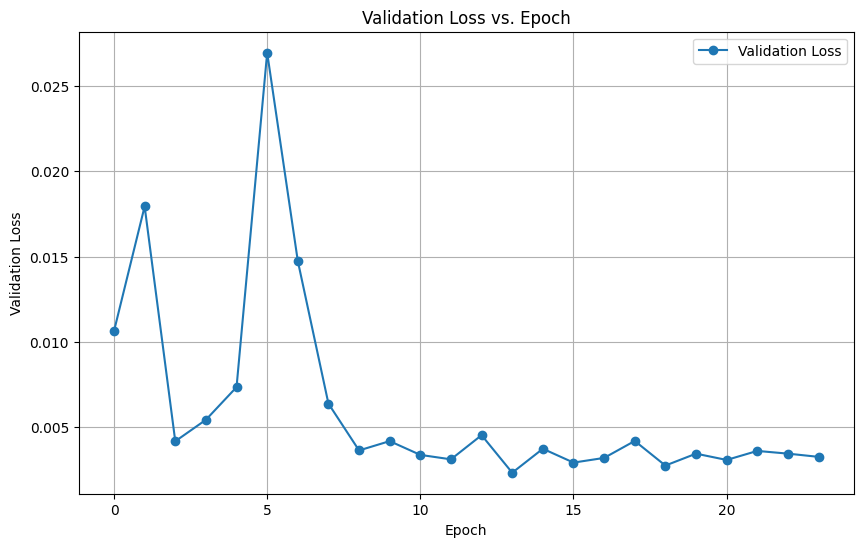

In [33]:
# retrive optimal trial results
log_directory = '/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/exp/optuna/bestparam5/trial_12/'

# list all Parquet files in the directory
parquet_files = [f for f in os.listdir(log_directory) if f.endswith('.parquet')]

# initialize an empty list to store DataFrames
df_list = []

# read all Parquet files and append them to the list
for file in parquet_files:
    file_path = os.path.join(log_directory, file)
    df = pd.read_parquet(file_path)
    df_list.append(df)

# concatenate all DataFrames into a single DataFrame
full_df = pd.concat(df_list, ignore_index=True)
full_df = full_df.drop_duplicates().reset_index(drop=True)

# extract the epoch and validation loss columns
epochs = full_df['epoch']
val_loss = full_df['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epoch')
plt.legend()
plt.grid()
plt.show()

In [34]:
full_df

,epoch,val_loss,precision,recall,TNR,FPR,FNR,accuracy,f1,auc,positive_ratio_eval_pred,positive_ratio_eval_Y
0,0,0.010641,0.015232,0.743180,0.946839,0.053161,0.256820,0.946614,0.029851,0.900759,0.076140,0.001105
1,1,0.017947,0.042157,0.080903,0.997966,0.002034,0.919097,0.996953,0.055430,0.931273,0.331252,0.001105
2,2,0.004186,0.027028,0.467545,0.981378,0.018622,0.532455,0.980810,0.051101,0.925355,0.038583,0.001105
3,3,0.005444,0.028436,0.818909,0.969043,0.030957,0.181091,0.968877,0.054963,0.938834,0.051979,0.001105
4,4,0.007356,0.019726,0.815616,0.955155,0.044845,0.184384,0.955001,0.038520,0.952351,0.213811,0.001105
5,5,0.026949,0.007104,0.528692,0.918243,0.081757,0.471308,0.917813,0.014019,0.787033,0.445062,0.001105
6,6,0.014751,0.015361,0.782690,0.944490,0.055510,0.217310,0.944311,0.030130,0.926802,0.061095,0.001105
7,7,0.006392,0.021072,0.878645,0.954839,0.045161,0.121355,0.954755,0.041158,0.949574,0.087443,0.001105
8,8,0.003650,0.037888,0.849012,0.976146,0.023854,0.150988,0.976006,0.072538,0.959088,0.050335,0.001105
9,9,0.004195,0.029574,0.809501,0.970611,0.029389,0.190499,0.970433,0.057063,0.951880,0.039237,0.001105


<Axes: xlabel='epoch'>

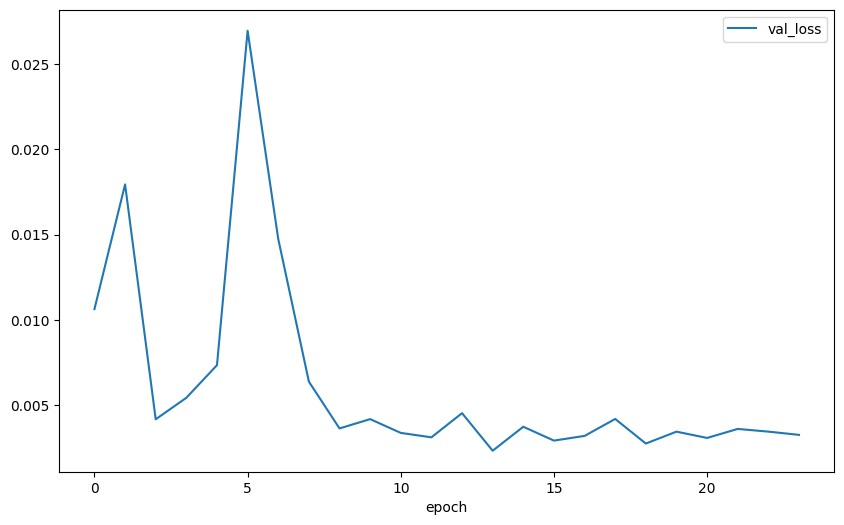

In [ ]:
full_df.plot(x="epoch", y=["val_loss"])

<Axes: xlabel='epoch'>

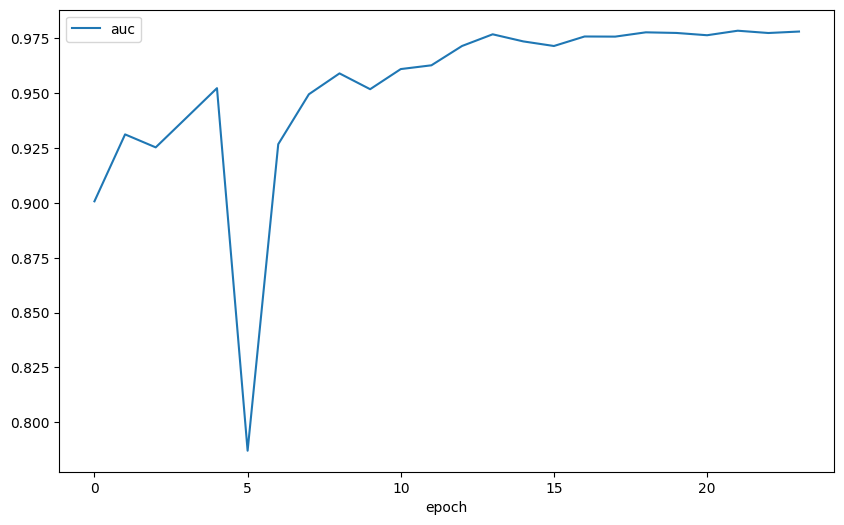

In [ ]:
full_df.plot(x="epoch", y="auc")

<Axes: xlabel='epoch'>

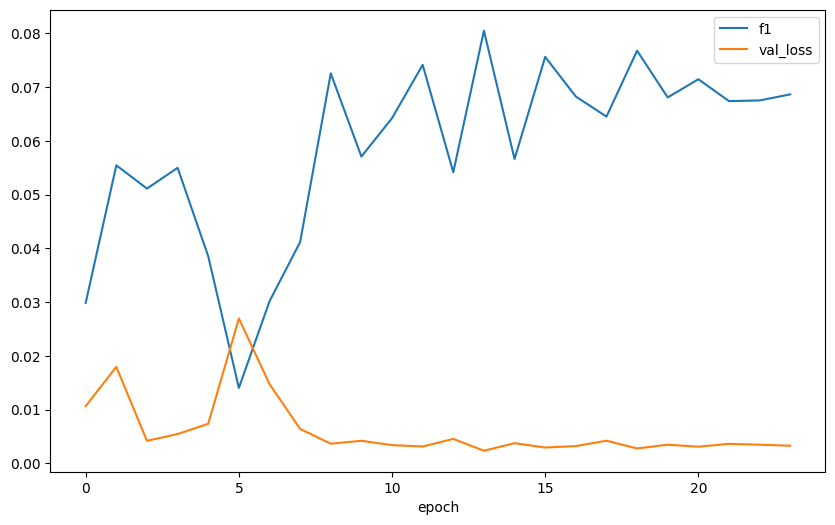

In [36]:
#plot f1 and val_loss in the same graph
full_df.plot(x="epoch", y=["f1", "val_loss"])


### Optimal model

In [16]:
# retrive optimal model
bestmodel_path = "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/exp/optuna/bestparam5/trial_12/model_trial_None_epoch_23.bin"
bestmodel = torch.load(bestmodel_path)
bestmodel.eval()   # Set to evaluation mode

<ipython-input-16-8a8dd5dfd797>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bestmodel = torch.load(bestmodel_path)


AmlLstm(
  (embedded_features): ModuleList(
    (0): Embedding(43557, 35)
    (1): Embedding(7, 2)
    (2): Embedding(24, 3)
    (3): Embedding(2, 1)
    (4): Embedding(43557, 35)
    (5-6): 2 x Embedding(13, 2)
    (7-8): 2 x Embedding(18, 3)
  )
  (in_fc_layers): ModuleList(
    (0): Dropout(p=0.005142082125976194, inplace=False)
    (1): Linear(in_features=88, out_features=80, bias=True)
    (2): Dropout(p=0.005142082125976194, inplace=False)
    (3): Linear(in_features=80, out_features=40, bias=True)
    (4): Dropout(p=0.005142082125976194, inplace=False)
    (5): Linear(in_features=40, out_features=15, bias=True)
  )
  (lstm_layer): ModuleList(
    (0): LSTM(15, 65, batch_first=True)
  )
  (output_layers): ModuleList(
    (0): Dropout(p=0.005142082125976194, inplace=False)
    (1): Linear(in_features=65, out_features=50, bias=True)
    (2): Dropout(p=0.005142082125976194, inplace=False)
    (3): Linear(in_features=50, out_features=45, bias=True)
    (4): Dropout(p=0.00514208212597

# Test optimal model on "Test set"

In [17]:
def test_one_epoch(dataloader, bestmodel, criterion, positive_weight):
    total_test_events = 0
    total_positives_test_Y = 0
    total_positives_test_pred = 0
    all_preds_test = []
    all_targets_test = []
    total_val_loss_test = 0


    with torch.no_grad():
        for X, Y in dataloader:
            pred = bestmodel(X)
            val_loss = compute_weighted_BCELoss(
                pred, Y, criterion, positive_weight=positive_weight
            )
            total_val_loss_test += val_loss.item()
            all_preds_test.append(pred)
            all_targets_test.append(Y)

    all_preds_test = torch.squeeze(torch.cat(all_preds_test), dim=1)
    all_targets_test = torch.squeeze(torch.cat(all_targets_test))
    total_test_events += len(all_targets_test)
    total_positives_test_pred += all_preds_test.sum().item()
    total_positives_test_Y += all_targets_test.sum().item()
    avg_val_loss_test = total_val_loss_test / total_test_events

    # Compute metrics
    precision, recall, TNR, FPR, FNR, accuracy, f1, auc = compute_metrics(all_preds_test, all_targets_test)
    positive_ratio_test_pred = total_positives_test_pred / total_test_events
    positive_ratio_test_Y = total_positives_test_Y / total_test_events

    print(f"Metrics:")
    print(f"Validation loss: {avg_val_loss_test}")
    print(f"Precision: {precision:.3f}, Recall (TPR): {recall:.3f}, TNR: {TNR:.3f}")
    print(f"FPR: {FPR:.3f}, FNR: {FNR:.3f}, Accuracy: {accuracy:.3f}, F1 Score: {f1:.3f}, AUC: {auc:.3f}")
    print(f"positive stats {positive_ratio_test_pred }: {positive_ratio_test_Y}")

    return avg_val_loss_test, precision, recall, TNR, FPR, FNR, accuracy, f1, auc,  \
      positive_ratio_test_pred, positive_ratio_test_Y, all_preds_test, all_targets_test


In [18]:
def test(dataloader_test, bestmodel, criterion, positive_weight):
    """
    Test the best model on the testing dataset and evaluate its performance.
    """
    avg_val_loss_test, precision, recall, TNR, FPR, FNR, accuracy, f1, auc, \
    positive_ratio_test_pred, positive_ratio_test_Y, all_preds_test, all_targets_test = test_one_epoch(
        dataloader_test, bestmodel, criterion, positive_weight
    )

    # Log final metrics
    test_results = {
        "val_loss_test": avg_val_loss_test,
        "precision": precision,
        "recall": recall,
        "TNR": TNR,
        "FPR": FPR,
        "FNR": FNR,
        "accuracy": accuracy,
        "f1": f1,
        "auc": auc,
        "positive_ratio_test_pred": positive_ratio_test_pred,
        "positive_ratio_test_Y": positive_ratio_test_Y,
    }
    print("\nFinal Testing Metrics:")
    for metric, value in test_results.items():
        print(f"{metric}: {value:.4f}")

    return test_results, all_preds_test, all_targets_test

In [19]:
criterion = torch.nn.BCELoss()
positive_weight = 31  # Adjust according to optuna
test_dataloader = aml_test_dataloader_id2
save_path = "/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/exp/test/8"
os.makedirs(save_path, exist_ok=True)

In [20]:
# Test the model for one epoch
avg_val_loss_test, precision, recall, TNR, FPR, FNR, accuracy, f1, auc, \
positive_ratio_test_pred, positive_ratio_test_Y, all_preds_test, all_targets_test = test_one_epoch(
    test_dataloader, bestmodel, criterion, positive_weight
)

# Log results
epoch_results = {
    "val_loss": avg_val_loss_test,
    "precision": precision,
    "recall": recall,
    "accuracy": accuracy,
    "f1_score": f1,
    "auc": auc,
    'positive_ratio_test_pred': positive_ratio_test_pred,
    'positive_ratio_test_Y': positive_ratio_test_Y,
    'FNR': FNR,
    'FPR': FPR,
    'TNR': TNR,
    'all_preds_test': all_preds_test.tolist(),
    'all_targets_test': all_targets_test.tolist()
}

# Convert PyTorch tensors to Python native types
epoch_results = {
    key: value.item() if isinstance(value, torch.Tensor) else value
    for key, value in epoch_results.items()
}

# Save results to a DataFrame, parquet
df_log = pd.DataFrame([epoch_results])
final_file_name = "df_log_test.parquet"
df_log.to_parquet(os.path.join(save_path, final_file_name), engine="pyarrow", index=False)

print("\n--- Test Results ---")
for key, value in epoch_results.items():
    if isinstance(value, (int, float)):
        print(f"{key.upper()}: {value:.4f}")
    elif isinstance(value, list):  # If the value is a list, print it as is
        print(f"{key.upper()}: {len(value)} items")
        # Optionally print a portion of the list to avoid excessive output:
        print(f"Sample of {key.upper()}: {value[:5]} ...")  # First 5 elements of the list
    else:
        print(f"{key.upper()}: {value}")

Metrics:
Validation loss: 0.002904873611276931
Precision: 0.034, Recall (TPR): 0.882, TNR: 0.975
FPR: 0.025, FNR: 0.118, Accuracy: 0.975, F1 Score: 0.066, AUC: 0.979
positive stats 0.03760612655421028: 0.0009990083566338837

--- Test Results ---
VAL_LOSS: 0.0029
PRECISION: 0.0342
RECALL: 0.8820
ACCURACY: 0.9750
F1_SCORE: 0.0658
AUC: 0.9786
POSITIVE_RATIO_TEST_PRED: 0.0376
POSITIVE_RATIO_TEST_Y: 0.0010
FNR: 0.1180
FPR: 0.0249
TNR: 0.9751
ALL_PREDS_TEST: 1900885 items
Sample of ALL_PREDS_TEST: [0.3074181079864502, 0.04051072150468826, 0.020343996584415436, 0.017444128170609474, 0.018037019297480583] ...
ALL_TARGETS_TEST: 1900885 items
Sample of ALL_TARGETS_TEST: [0.0, 0.0, 0.0, 0.0, 0.0] ...


# Result Analysis

In [21]:
besttest = pd.read_parquet("/content/drive/MyDrive/DE/Master_Degree/3rd_Semester/Colab_Notebook/AML_file/exp/test/8/df_log_test.parquet")
besttest

,val_loss,precision,recall,accuracy,f1_score,auc,positive_ratio_test_pred,positive_ratio_test_Y,FNR,FPR,TNR,all_preds_test,all_targets_test
0,0.002905,0.034154,0.882043,0.974964,0.065762,0.978562,0.037606,0.000999,0.117957,0.024943,0.975057,"[0.3074181079864502, 0.04051072150468826, 0.02...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
# access first set of predictions & target lables from the stored results in besttest
all_preds_test = besttest.all_preds_test[0]
all_targets_test = besttest.all_targets_test[0]

# convert the predictions & target lables into a PyTorch tensor for compatibility with further computations.
all_preds_test = torch.tensor(all_preds_test)
all_targets_test = torch.tensor(all_targets_test)

# check dimensions
print(all_preds_test.shape)
print(all_targets_test.shape)

torch.Size([1900885])
torch.Size([1900885])


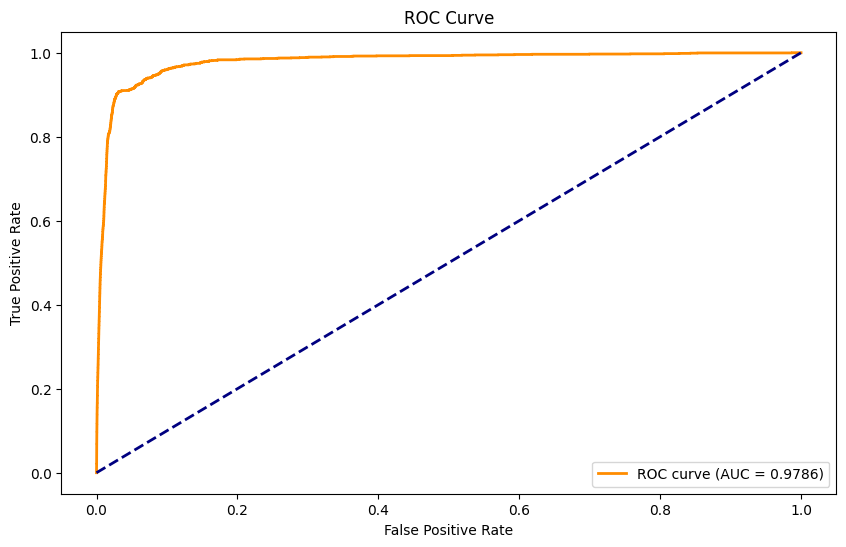

In [25]:
# calculate false positive rate, true positive rate, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(all_targets_test, all_preds_test)
roc_auc = auc(fpr, tpr)

# plot roc_auc
plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc(fpr, tpr):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [26]:
len(fpr), len(thresholds)

(403786, 403786)

In [28]:
# select some point for anotation in graph to reduce data density
interval = 100000  # include every 100,000th point
trimmed_coordinates = [] # initialize a list to store selected threshold, FPR, and TPR values.

for i, (threshold_i, fpr_i, tpr_i) in enumerate(zip(thresholds, fpr, tpr)): #keep points that are at every 100,000th index, and at specific observation (e.g., 1, 3000, 3500, etc.).
    if (i % interval == 0) or (i == 1) or (i == 3000) or (i == 3500) or (i == 4000) or (i == 4150) or (i == 6000) or (i == 10000) or (i == 13000) or (i == 20000) or (i == 30000) or (i == 40000):
        trimmed_coordinates.append((threshold_i, fpr_i, tpr_i)) #append selected points.

trimmed_coordinates

[(inf, 0.0, 0.0),
 (0.9999991655349731, 0.0, 0.000526592943654555),
 (0.9413837790489197, 0.010848421210056315, 0.6292785676671933),
 (0.890830397605896, 0.014286045289433414, 0.7398630858346498),
 (0.720743715763092, 0.020948548330530083, 0.8420221169036335),
 (0.5467442870140076, 0.02438722560355895, 0.8778304370721433),
 (0.25403618812561035, 0.041660654686237815, 0.909952606635071),
 (0.07934768497943878, 0.07944924291174342, 0.9426013691416535),
 (0.019018646329641342, 0.12404146212768288, 0.9705107951553449),
 (0.008405589498579502, 0.17301812651594062, 0.9831490258030542),
 (0.007885039784014225, 0.19505146430779374, 0.9831490258030542),
 (0.007068090606480837, 0.22096160793181202, 0.9852553975776724),
 (0.0026782904751598835, 0.40289817829094055, 0.9926276987888363),
 (0.0018770287279039621, 0.5818563170028637, 0.995260663507109),
 (0.0012721767416223884, 0.767075691974559, 0.9973670352817272),
 (0.0007856374722905457, 0.9650566144247509, 0.9994734070563455)]

In [29]:
# adjust point to not too close to each other
trimmed_coordinates = trimmed_coordinates[1:] #skip first element
trimmed_coordinates = trimmed_coordinates[0:8] + trimmed_coordinates[9:10] + trimmed_coordinates[11:]
trimmed_coordinates

[(0.9999991655349731, 0.0, 0.000526592943654555),
 (0.9413837790489197, 0.010848421210056315, 0.6292785676671933),
 (0.890830397605896, 0.014286045289433414, 0.7398630858346498),
 (0.720743715763092, 0.020948548330530083, 0.8420221169036335),
 (0.5467442870140076, 0.02438722560355895, 0.8778304370721433),
 (0.25403618812561035, 0.041660654686237815, 0.909952606635071),
 (0.07934768497943878, 0.07944924291174342, 0.9426013691416535),
 (0.019018646329641342, 0.12404146212768288, 0.9705107951553449),
 (0.007885039784014225, 0.19505146430779374, 0.9831490258030542),
 (0.0026782904751598835, 0.40289817829094055, 0.9926276987888363),
 (0.0018770287279039621, 0.5818563170028637, 0.995260663507109),
 (0.0012721767416223884, 0.767075691974559, 0.9973670352817272),
 (0.0007856374722905457, 0.9650566144247509, 0.9994734070563455)]

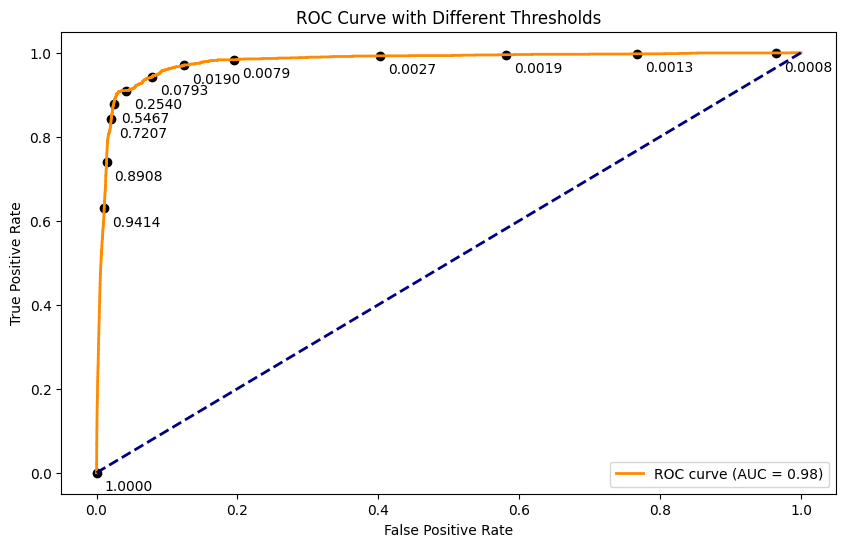

In [30]:
# plot on ROC-AUC along with different threshold

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')

# anotate thresholds
for i, (threshold, fpr_i, tpr_i) in enumerate(trimmed_coordinates):
    plt.annotate(f'{threshold:.4f}', (fpr_i, tpr_i), textcoords="offset points", xytext=(23, -13), ha='center')
    plt.scatter(fpr_i, tpr_i, color='black', marker='o')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Different Thresholds')
plt.legend()
plt.show()


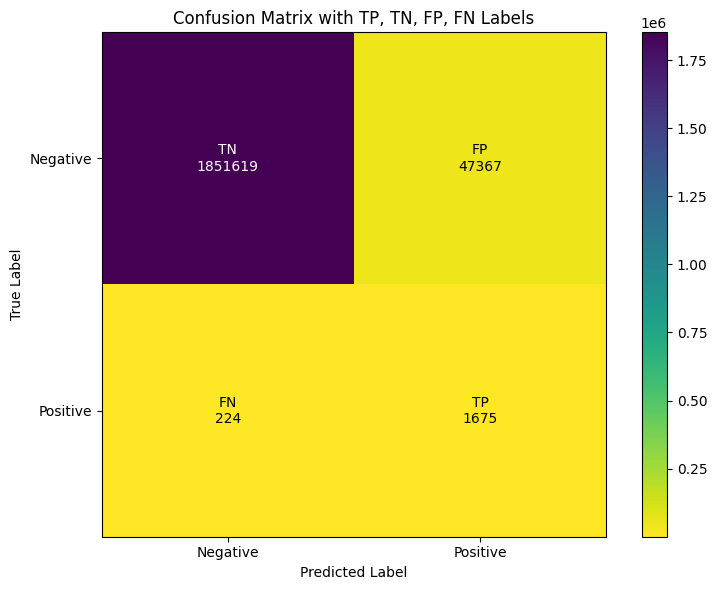

In [31]:
# plot confusion metrix
y_true = np.array(all_targets_test)
y_scores = np.array(all_preds_test)

cm = confusion_matrix(y_true, y_scores.round())
cmap = plt.cm.viridis_r
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

# add a color bar
plt.colorbar(im, ax=ax)

# labeing class names, name of x-asix, y-aisx
classes = ['Negative', 'Positive']
ax.set(xticks=np.arange(len(classes)),
       yticks=np.arange(len(classes)),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted Label',
       ylabel='True Label')

# annotate cells with values and TP, TN, FP, FN labels
labels = [['TN', 'FP'], ['FN', 'TP']]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{labels[i][j]}\n{cm[i, j]}",
                ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.title('Confusion Matrix with TP, TN, FP, FN Labels')
plt.tight_layout()
plt.show()

In [32]:
1851619+47367+224+1675

1900885